<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/macormack_v6_optimized_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MacCormack Simulation v6.1
Optimized scramjet nozzle with combustion and Mach > 5

In [2]:
# Step 1: Load isentropic initial profile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("macormack_v6_isentropic_init.csv")
x = data["x"].values
A = data["Area"].values
rho = data["Density"].values
u = data["Velocity"].values
p = data["Pressure"].values
T = data["Temperature"].values
YH = data["Y_H2"].values
YO2 = data["Y_O2"].values
YP = data["Y_Products"].values

In [3]:
# Step 2: Setup constants and energy
gamma = 1.4
R = 287.0
E = p / (gamma - 1) + 0.5 * rho * u**2

In [4]:
# Step 3: Reaction model and simulation parameters
A0 = 800
Ea = 2e4
Q_release = 1e5
def reaction_rate(T, rho, YH, YO2):
    T_clip = np.clip(T, 300, 6000)
    expo = np.exp(-Ea / (8.314 * T_clip))
    w = A0 * expo * rho**2 * YH * YO2
    return np.minimum(w, 1e4)

dx = x[1] - x[0]
CFL = 0.3
nt = 10000
epsilon = 0.006
E_max = 1e7
u_max = 4000

In [5]:
# Step 4: Time integration loop
for t in range(nt):
    c = np.sqrt(gamma * R * T)
    dt = CFL * dx / np.max(np.abs(u) + c)
    F1 = rho * u
    F2 = rho * u**2 + p
    F3 = (E + p) * u
    rho_p = rho.copy()
    u_p = u.copy()
    E_p = E.copy()
    rho_p[:-1] -= dt / dx * (F1[1:] - F1[:-1])
    u_p[:-1] -= dt / dx * (F2[1:] - F2[:-1]) / rho[:-1]
    E_p[:-1] -= dt / dx * (F3[1:] - F3[:-1]) / A[:-1]
    p_p = (gamma - 1) * (E_p - 0.5 * rho_p * u_p**2)
    F1_p = rho_p * u_p
    F2_p = rho_p * u_p**2 + p_p
    F3_p = (E_p + p_p) * u_p
    rho -= dt / (2 * dx) * (F1_p - np.roll(F1_p, 1))
    u -= dt / (2 * dx) * (F2_p - np.roll(F2_p, 1)) / rho
    E -= dt / (2 * dx) * (F3_p - np.roll(F3_p, 1)) / A
    rho += epsilon * (np.roll(rho, -1) - 2 * rho + np.roll(rho, 1))
    u += epsilon * (np.roll(u, -1) - 2 * u + np.roll(u, 1))
    E += epsilon * (np.roll(E, -1) - 2 * E + np.roll(E, 1))
    E = np.clip(E, 1e3, E_max)
    u = np.clip(u, 0, u_max)
    T = np.clip(p / (rho * R), 300, 6000)
    w = reaction_rate(T, rho, YH, YO2)
    E += dt * Q_release * w
    YH = np.clip(YH - dt * w / rho, 0, 1)
    YO2 = np.clip(YO2 - dt * 0.5 * w / rho, 0, 1)
    YP = np.clip(1 - YH - YO2, 0, 1)
    p = (gamma - 1) * (E - 0.5 * rho * u**2)
    T = np.clip(p / (rho * R), 300, 6000)
    rho[0], T[0], YH[0], YO2[0], YP[0] = rho[1], T[1], YH[1], YO2[1], YP[1]
    u[0] = u[1]
    p[0] = p[1]
    u[-1] = u[-2]
    p[-1] = p[-2]

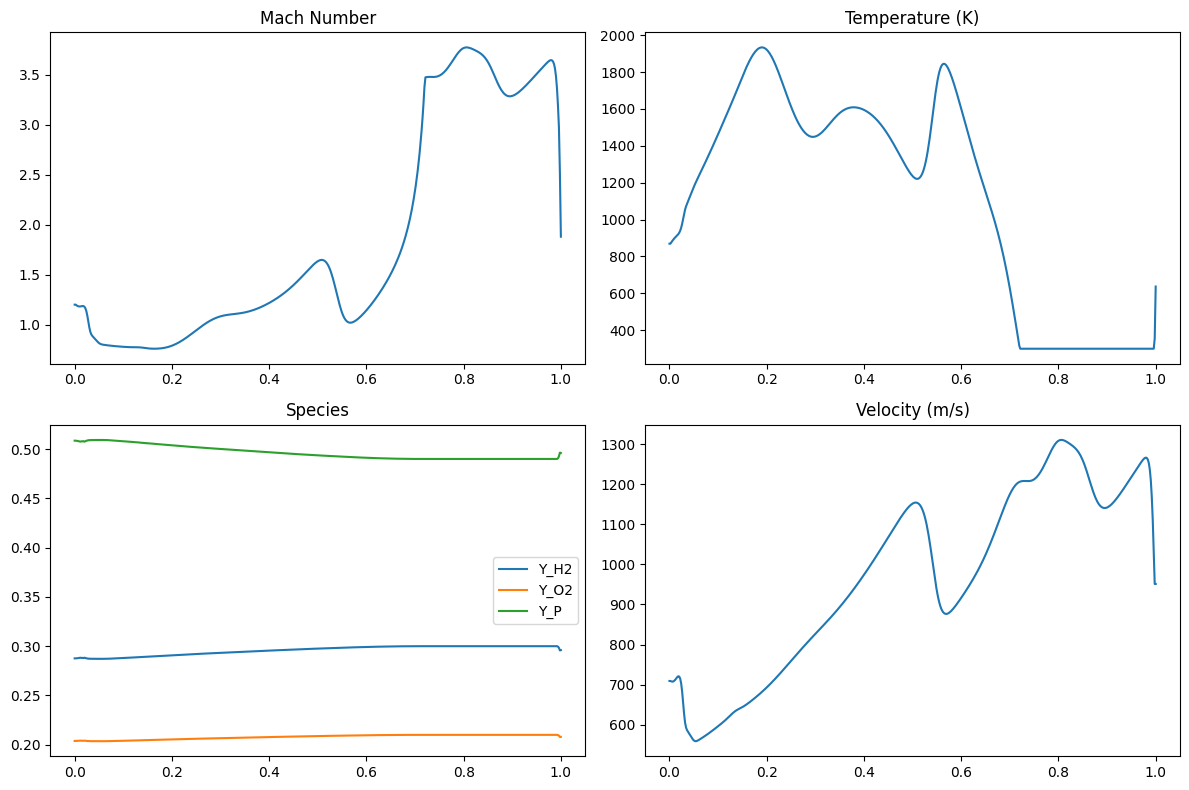

In [6]:
# Step 5: Plot final results
M = u / np.sqrt(gamma * R * T)
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1); plt.plot(x, M); plt.title('Mach Number')
plt.subplot(2, 2, 2); plt.plot(x, T); plt.title('Temperature (K)')
plt.subplot(2, 2, 3); plt.plot(x, YH, label='Y_H2'); plt.plot(x, YO2, label='Y_O2'); plt.plot(x, YP, label='Y_P'); plt.legend(); plt.title('Species')
plt.subplot(2, 2, 4); plt.plot(x, u); plt.title('Velocity (m/s)')
plt.tight_layout(); plt.show()